In [35]:
import numpy as np
import matplotlib.pyplot as plt
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    make_scorer, 
    accuracy_score, 
    recall_score
)
from fairlearn.metrics import (
    count,
    MetricFrame,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    true_negative_rate,
    demographic_parity_difference
)
from fairlearn.datasets import fetch_adult
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from metrics import (
    equality_opportunity_difference,
    predictive_equality_difference,
    metrics
)

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.termination import get_termination
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.crossover.hux import HalfUniformCrossover


In [36]:
data = fetch_adult(as_frame=True)
X_raw = data.data
y = (data.target == ">50K") * 1
A = X_raw["sex"]

features = X_raw.columns
n_cols = len(X_raw.columns)
num_features = X_raw._get_numeric_data().columns
cat_features =  [col for col in X_raw.columns if col not in num_features]


/home/azucena/miniconda3/envs/fairenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [37]:
numeric_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
        
    ], remainder = "drop"
)


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(n_jobs=-1)
        ),
    ]
)

In [38]:

algorithm = NSGA2(
    pop_size = 50,
    sampling = BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates = True,
)

termination = get_termination("n_gen", 20)
metric_scorer_decorated =  metrics(f1_score, predictive_equality_difference, sensitive_col = 'sex')

In [39]:
results = []

In [40]:
for sim in [0,1,2,3]:
    print(sim)
    (X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, y, A, test_size=0.3, stratify=y, random_state=sim
)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    A_train = A_train.reset_index(drop=True)
    A_test = A_test.reset_index(drop=True)

    class MyProblem(Problem):

        def __init__(self):
            super().__init__(n_var=n_cols,
                            n_obj=2
                            )


        def _evaluate(self, x, out, *args, **kwargs):
            fair_metric = []
            model_metric = []
            for x_ in x:
                features_ = features[np.where(x_)[0]]
                num_features_ = [x for x in num_features if x in features_]
                cat_features_ = [x for x in cat_features if x in features_]
                preprocessor = ColumnTransformer(
                    transformers=[
                        ("num", numeric_transformer, num_features_),
                        ("cat", categorical_transformer, cat_features_),
                        
                    ], remainder = "drop"
                )

                pipeline.steps.pop(0)
                pipeline.steps.insert(0,('preprocessor',preprocessor))
                # optimization function (hyperparam response function)
                if (np.repeat(False,n_cols) == x_).all():
                    fair_metric.append(100)
                    model_metric.append(100)
                else: 
                    scores = cross_validate(
                            pipeline, 
                            X_train,
                            y_train, 
                            cv=5,
                            scoring= metric_scorer_decorated,
                            return_train_score=True)

                    #fair_metric.append(scores['test_eod'].mean())
                    fair_metric.append(scores['test_fairness'].mean())
                    model_metric.append(-1*scores['test_model'].mean())
            out["F"] = [fair_metric, model_metric]
   

    problem = MyProblem()

    results.append( 
        minimize(
            problem,
            algorithm,
            termination,
            save_history = True
        )
    )

    


0


In [33]:
results

In [34]:
import dill
file_name = 'results_recall_fpr_4sim.pkl'
with open(file_name, 'wb') as file:
    dill.dump(results, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "results_recall_fpr_4sim.pkl"


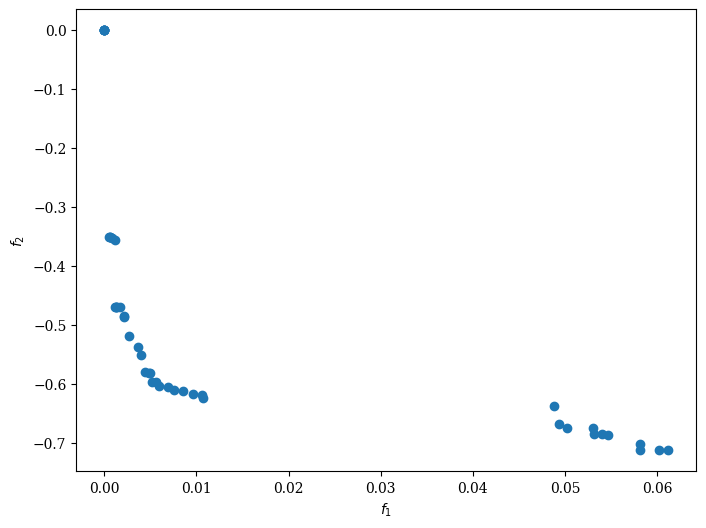

In [14]:
n = 0
from pymoo.visualization.scatter import Scatter

Scatter().add(results[n].F).show()


In [49]:
results[n_sim].F[:,0].argsort()
for n_pop in results[n].F[:,0].argsort():
    pop = results[n].opt
    print(features[pop.get("X")[n_pop]])

NameError: name 'n_sim' is not defined